In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv('diabetic_data.csv')

In [5]:
data.shape

(101766, 50)

In [6]:
data.replace('?', pd.NA, inplace=True)

In [7]:

missing_values_percent = data.isna().mean() * 100

missing_values_percent[missing_values_percent > 0].sort_values(ascending=False)

weight               96.858479
medical_specialty    49.082208
payer_code           39.557416
race                  2.233555
diag_3                1.398306
diag_2                0.351787
diag_1                0.020636
dtype: float64

In [8]:
data = data.drop('encounter_id', axis=1)

In [9]:
data.shape

(101766, 49)

In [10]:
# Convert 'readmitted' to binary classification
def convert_readmission(value):
  if value == '<30':
    return 1
  else:
    return 0

data['readmitted'] = data['readmitted'].apply(convert_readmission)


In [11]:
display(data.iloc[12])

patient_nbr                               85504905
race                                     Caucasian
gender                                      Female
age                                        [40-50)
weight                                        <NA>
admission_type_id                                1
discharge_disposition_id                         3
admission_source_id                              7
time_in_hospital                                 7
payer_code                                    <NA>
medical_specialty           Family/GeneralPractice
num_lab_procedures                              60
num_procedures                                   0
num_medications                                 15
number_outpatient                                0
number_emergency                                 1
number_inpatient                                 0
diag_1                                         428
diag_2                                      250.43
diag_3                         

In [12]:
data['readmitted'] = data['readmitted'].astype(bool)

In [13]:
print(data.dtypes)

patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide       

In [14]:
near_zero_variance_cols = ['repaglinide', 'nateglinide', 'chlorpropamide', 
                           'glimepiride', 'acetohexamide', 'tolbutamide', 
                           'acarbose', 'miglitol', 'troglitazone','examide', 'citoglipton',
                           'glipizide-metformin', 'glimepiride-pioglitazone', 
                           'metformin-rosiglitazone', 'metformin-pioglitazone']

data = data.drop(near_zero_variance_cols, axis=1) 

In [15]:
data.shape

(101766, 34)

In [16]:
numerical_columns = data.select_dtypes(include=np.number)
print(numerical_columns)

        patient_nbr  admission_type_id  discharge_disposition_id  \
0           8222157                  6                        25   
1          55629189                  1                         1   
2          86047875                  1                         1   
3          82442376                  1                         1   
4          42519267                  1                         1   
...             ...                ...                       ...   
101761    100162476                  1                         3   
101762     74694222                  1                         4   
101763     41088789                  1                         1   
101764     31693671                  2                         3   
101765    175429310                  1                         1   

        admission_source_id  time_in_hospital  num_lab_procedures  \
0                         1                 1                  41   
1                         7                 3

In [17]:
for column in ['race', 'diag_1', 'diag_2', 'diag_3']:
    most_frequent = data[column].mode()[0]
    data[column].fillna(most_frequent, inplace=True)

# Re-check missing values to confirm changes
data.isna().mean().sort_values(ascending=False).head()

weight               0.968585
medical_specialty    0.490822
payer_code           0.395574
max_glu_serum        0.000000
A1Cresult            0.000000
dtype: float64

In [18]:
data.shape

(101766, 34)

In [19]:
missing_values_percent = data.isna().mean() * 100

missing_values_percent[missing_values_percent > 0].sort_values(ascending=False)

weight               96.858479
medical_specialty    49.082208
payer_code           39.557416
dtype: float64

In [20]:
data = data.drop(columns=['weight'])

In [21]:
columns_to_fill = ['medical_specialty', 'payer_code']
for column in columns_to_fill:
    data[column].fillna('Unknown', inplace=True)

# Verify changes
print(data[columns_to_fill].isna().sum())

medical_specialty    0
payer_code           0
dtype: int64


In [22]:
data.shape

(101766, 33)

In [23]:
print(numerical_columns.describe())

        patient_nbr  admission_type_id  discharge_disposition_id  \
count  1.017660e+05      101766.000000             101766.000000   
mean   5.433040e+07           2.024006                  3.715642   
std    3.869636e+07           1.445403                  5.280166   
min    1.350000e+02           1.000000                  1.000000   
25%    2.341322e+07           1.000000                  1.000000   
50%    4.550514e+07           1.000000                  1.000000   
75%    8.754595e+07           3.000000                  4.000000   
max    1.895026e+08           8.000000                 28.000000   

       admission_source_id  time_in_hospital  num_lab_procedures  \
count        101766.000000     101766.000000       101766.000000   
mean              5.754437          4.395987           43.095641   
std               4.064081          2.985108           19.674362   
min               1.000000          1.000000            1.000000   
25%               1.000000          2.000000   

In [26]:
numerical_columns = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses']

outliers_percentage = {}

# Iterate over numerical columns
for column in numerical_columns:
    # Calculate Z-Score Method outliers
    z_scores = np.abs((data[column] - data[column].mean()) / data[column].std())
    outliers_zscore = (z_scores > 3)
    
    # Calculate percentage of outliers
    total_outliers = outliers_zscore.sum()
    total_count = len(data)
    percentage = (total_outliers / total_count) * 100
    
    outliers_percentage[column] = percentage

# Print percentage of outliers for each column
print("Percentage of outliers in each column using Z-score method:")
for column, percentage in outliers_percentage.items():
    print(f"{column}: {percentage:.2f}%")

Percentage of outliers in each column using Z-score method:
admission_type_id: 0.34%
discharge_disposition_id: 3.53%
admission_source_id: 0.17%
time_in_hospital: 1.02%
num_lab_procedures: 0.04%
num_procedures: 0.00%
num_medications: 1.34%
number_outpatient: 1.43%
number_emergency: 1.64%
number_inpatient: 1.98%
number_diagnoses: 0.28%


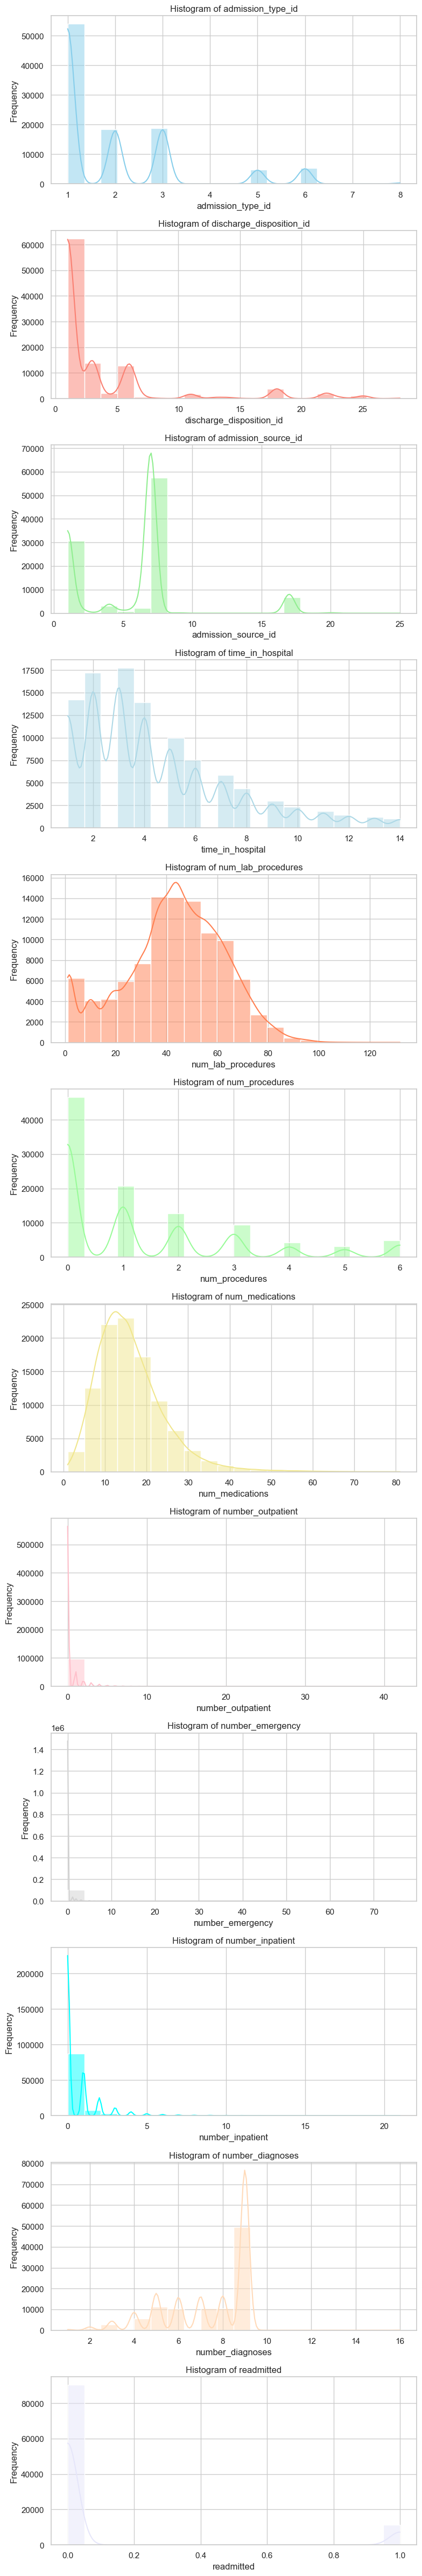

In [25]:
# Setting the seaborn style for the plots
sns.set(style="whitegrid")

# Create a figure and axis to plot histograms for multiple features
fig, axs = plt.subplots(12, 1, figsize=(8, 48))  # Adjusted for the number of variables

# List of features to plot
features = [
    'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

# Colors for the plots
colors = [
    'skyblue', 'salmon', 'lightgreen', 'lightblue', 'coral', 'palegreen',
    'khaki', 'pink', 'lightgrey', 'cyan', 'peachpuff', 'lavender'
]

# Loop through features and create histograms
for i, feature in enumerate(features):
    sns.histplot(data=data, x=feature, bins=20, kde=True, color=colors[i], ax=axs[i])
    axs[i].set_title(f'Histogram of {feature}')
    axs[i].set_xlabel(f'{feature}')
    axs[i].set_ylabel('Frequency')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [28]:
columns = [
    'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses'
]

# Apply log transformation (adding 1 to avoid log(0))
for column in columns:
    data[f'log_{column}'] = np.log1p(data[column])

In [29]:
# Function to remove outliers based on the IQR method for log-transformed data
def remove_outliers_log_transformed(df, log_column):
    Q1 = df[log_column].quantile(0.25)
    Q3 = df[log_column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[log_column] >= lower_bound) & (df[log_column] <= upper_bound)]

# Apply outlier removal for each log-transformed column
for column in columns:
    log_column = f'log_{column}'
    diabetic_data_cleaned = remove_outliers_log_transformed(data, log_column)

# Note: This will reduce the size of the dataset by removing rows with outliers in any of the transformed columns


NameError: name 'diabetic_data_cleaned' is not defined